# MIRI FM etalon line identification

This notebook is used to save all fitted centers and properties of fitted etalon lines observed with the MIRI MRS.

In [1]:
# import modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
import scipy.interpolate as scp_interpolate
from scipy.optimize import curve_fit
from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# > Set directories
user = "yannis" # "yannis"
if user == "alvaro":
    workDir = "./"
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"
cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/"
FTSlinefits   = MRSWaveCalDir+"FTS_ET_linefits/"

In [3]:
# give analysis inputs
band = '4C'                     # spectral band under investigation
islice = 11                     # slice number (equivalent to beta position)

In [4]:
# open files to store information
if band[0] in ['1','2']:
    save_et1a = open('data/Band'+str(band)+'_ET1A_slice'+str(islice)+'.txt', 'w')
    save_et1a.write('# Band '+str(band)+'   Etalon 1A   Slice '+str(islice)+'\n')
    save_et1a.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
    save_et1a.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
    save_et1a.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
    save_et1a.write('#    alpha       x  y      center         FWHM          skewness\n')

    save_et1b = open('data/Band'+str(band)+'_ET1B_slice'+str(islice)+'.txt', 'w')
    save_et1b.write('# Band '+str(band)+'   Etalon 1B   Slice '+str(islice)+'\n')
    save_et1b.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
    save_et1b.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
    save_et1b.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
    save_et1b.write('#    alpha       x  y      center         FWHM          skewness\n')
elif band[0] in ['4']:
    save_et2b = open('data/Band'+str(band)+'_ET2B_slice'+str(islice)+'.txt', 'w')
    save_et2b.write('# Band '+str(band)+'   Etalon 2B   Slice '+str(islice)+'\n')
    save_et2b.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
    save_et2b.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
    save_et2b.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
    save_et2b.write('#    alpha       x  y      center         FWHM          skewness\n')

In [5]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

In [6]:
# To account for the problematic lines at the top of the distorion maps
## WARNING: This should only be done for band 1C (and only if the distortion CDP version 06.04.00 is used, not the CDP7 version).
if band == "1C":
    d2cMaps['sliceMap'][0,:] = d2cMaps['sliceMap'][1,:]
    d2cMaps['alphaMap'][0,:] = d2cMaps['alphaMap'][1,:]
    d2cMaps['sliceMap'][-1,:] = d2cMaps['sliceMap'][-2,:]
    d2cMaps['alphaMap'][-1,:] = d2cMaps['alphaMap'][-2,:]

In [7]:
# Load etalon MRS and RAL FTS data files and data, and subtract BKG
if band[0] in ['1','2']:
    # Etalon_1A FM data
    sci_etalon1A_img,bkg_etalon1A_img = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A',output='img')
    # Etalon_1B FM data
    sci_etalon1B_img,bkg_etalon1B_img = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1B',output='img')
    
    etalon1A_img = sci_etalon1A_img-bkg_etalon1A_img
    etalon1B_img = sci_etalon1B_img-bkg_etalon1B_img
elif band[0] in ['4']:
    # Etalon_2B FM data
    sci_etalon2B_img,bkg_etalon2B_img = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET2B',output='img')
    etalon2B_img = sci_etalon2B_img-bkg_etalon2B_img

In [8]:
# Traces for each isoalpha are identified based on the following criteria:
if band[0] in ['1','2']:
    alpha_high,alpha_low,thres_e1a,min_dist_e1a,sigma0_e1a,thres_e1b,min_dist_e1b,sigma0_e1b = funcs.etalon_line_params(band)
elif band[0] in ['4']:
    alpha_high,alpha_low,thres_e2b,min_dist_e2b,sigma0_e2b = funcs.etalon_line_params(band)

In [9]:
alphas_inslice = funcs.slice_alphapositions(band,d2cMaps,sliceID=islice)
alphas_inslice = np.append(0,alphas_inslice)  # To include alpha=0, and put it at the beginning of the array

inds_al = np.where((alphas_inslice < alpha_high) & (alphas_inslice > alpha_low))  # we cut to this range to avoid issues with the edges of the slices.
alphas_inslice = alphas_inslice[inds_al]

print 'Along-slice positions: {} arcseconds'.format(alphas_inslice)

Along-slice positions: [ 0.        -2.7689439 -2.5412619 -2.3135799 -2.0858979 -1.8582159
 -1.6305339 -1.4028519 -1.1751699 -0.9474879 -0.7198059 -0.4921239
 -0.2644419 -0.0367599  0.1909221  0.4186041  0.6462861  0.8739681
  1.1016501  1.3293321  1.5570141  1.7846961  2.0123781  2.2400601
  2.4677421  2.6954241  2.9231061  3.1507881  3.3784701  3.6061521] arcseconds


### Perform analysis for single trace (use for debugging, if need be)

<IPython.core.display.Javascript object>


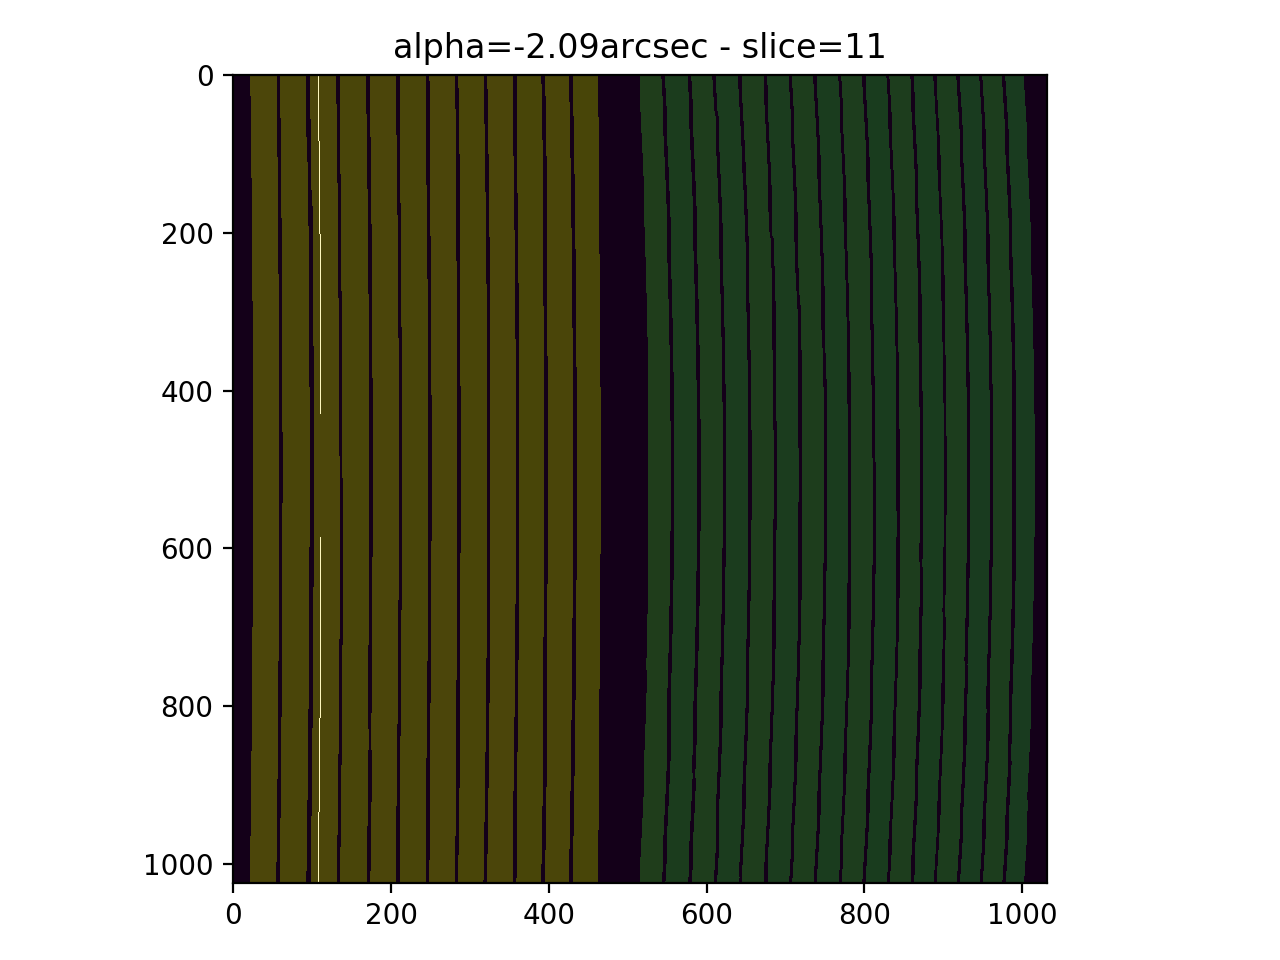

In [10]:
alpha_pos = alphas_inslice[4]

# Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)
if band == '1C':
    xpos[0] = xpos[1]
    xpos[-1] = xpos[-2]

valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.
plt.figure()
plt.title("alpha={}arcsec - slice={}".format(round(alpha_pos,2),islice))
plt.imshow(sliceMap,zorder=0)
plt.imshow(valid_img,cmap='gray',alpha=0.7,zorder=1)
plt.tight_layout()

In [11]:
# Choose data regions
if band[0] in ['1','2']:
    #--FM data
    etalon1A_fm_data = etalon1A_img[ypos,xpos]
    etalon1B_fm_data = etalon1B_img[ypos,xpos]

    # Determine etalon peaks
    #--FM Etalon_1A data
    if user == 'yannis':
        etalon1A_fm_data[np.isnan(etalon1A_fm_data)] = -1
        FMetalon1A_peaks = funcs.find_peaks(etalon1A_fm_data,thres=thres_e1a,min_dist=min_dist_e1a)
        FMetalon1A_peaks = FMetalon1A_peaks[(FMetalon1A_peaks>1) & (FMetalon1A_peaks<1022)]
    if user == 'alvaro':
        picos_1A, y_pixs_1A = funcs.find_max(etalon1A_fm_data,np.arange(1,1025,1.),maxcut_1a,toler_1a) # maxcut, wavel_toler
        picos_inds_1A = y_pixs_1A-1
        FMetalon1A_peaks = picos_inds_1A.astype(int)
    etalon1A_fm_data[(etalon1A_fm_data == -1)] = np.nan
    etalon1A_fm_data_noNaN = etalon1A_fm_data.copy()
    etalon1A_fm_data_noNaN[np.isnan(etalon1A_fm_data)] = 0.

    #--FM Etalon_1B data
    if user == 'yannis':
        etalon1B_fm_data[np.isnan(etalon1B_fm_data)] = -1
        FMetalon1B_peaks = funcs.find_peaks(etalon1B_fm_data,thres=thres_e1b,min_dist=min_dist_e1b)
        FMetalon1B_peaks = FMetalon1B_peaks[(FMetalon1B_peaks>1) & (FMetalon1B_peaks<1022)]
    if user == 'alvaro':
        picos_1B, y_pixs_1B = funcs.find_max(etalon1B_fm_data,np.arange(1,1025,1.),maxcut_1b,toler_1b) # maxcut, wavel_toler
        picos_inds_1B = y_pixs_1B-1
        FMetalon1B_peaks = picos_inds_1B.astype(int)
    etalon1B_fm_data[(etalon1B_fm_data == -1)] = np.nan
    etalon1B_fm_data_noNaN = etalon1B_fm_data.copy()
    etalon1B_fm_data_noNaN[np.isnan(etalon1B_fm_data)] = 0.

    print("Number of identified etalon lines :     [alpha = "+str(alpha_pos)+"]\n FM ET_1A etalon data: {} lines \n FM ET_1B etalon data: {} lines".format(len(FMetalon1A_peaks),len(FMetalon1B_peaks)))

elif band[0] in ['4']:
    #--FM data
    etalon2B_fm_data = etalon2B_img[ypos,xpos]

    # Determine etalon peaks
    #--FM Etalon_2B data
    if user == 'yannis':
        etalon2B_fm_data[np.isnan(etalon2B_fm_data)] = -1
        FMetalon2B_peaks = funcs.find_peaks(etalon2B_fm_data,thres=thres_e2b,min_dist=min_dist_e2b)
        FMetalon2B_peaks = FMetalon2B_peaks[(FMetalon2B_peaks>1) & (FMetalon2B_peaks<1022) & (etalon2B_fm_data[FMetalon2B_peaks]>0)]
    if user == 'alvaro':
        picos_2B, y_pixs_2B = funcs.find_max(etalon2B_fm_data,np.arange(1,1025,1.),maxcut_1a,toler_1a) # maxcut, wavel_toler
        picos_inds_2B = y_pixs_2B-1
        FMetalon2B_peaks = picos_inds_2B.astype(int)
    etalon2B_fm_data[(etalon2B_fm_data == -1)] = np.nan
    etalon2B_fm_data_noNaN = etalon2B_fm_data.copy()
    etalon2B_fm_data_noNaN[np.isnan(etalon2B_fm_data)] = 0.

    print("Number of identified etalon lines :     [alpha = "+str(alpha_pos)+"]\n FM ET_2B etalon data: {} lines".format(len(FMetalon2B_peaks)))

Number of identified etalon lines :     [alpha = -2.08589789633]
 FM ET_2B etalon data: 18 lines


<IPython.core.display.Javascript object>


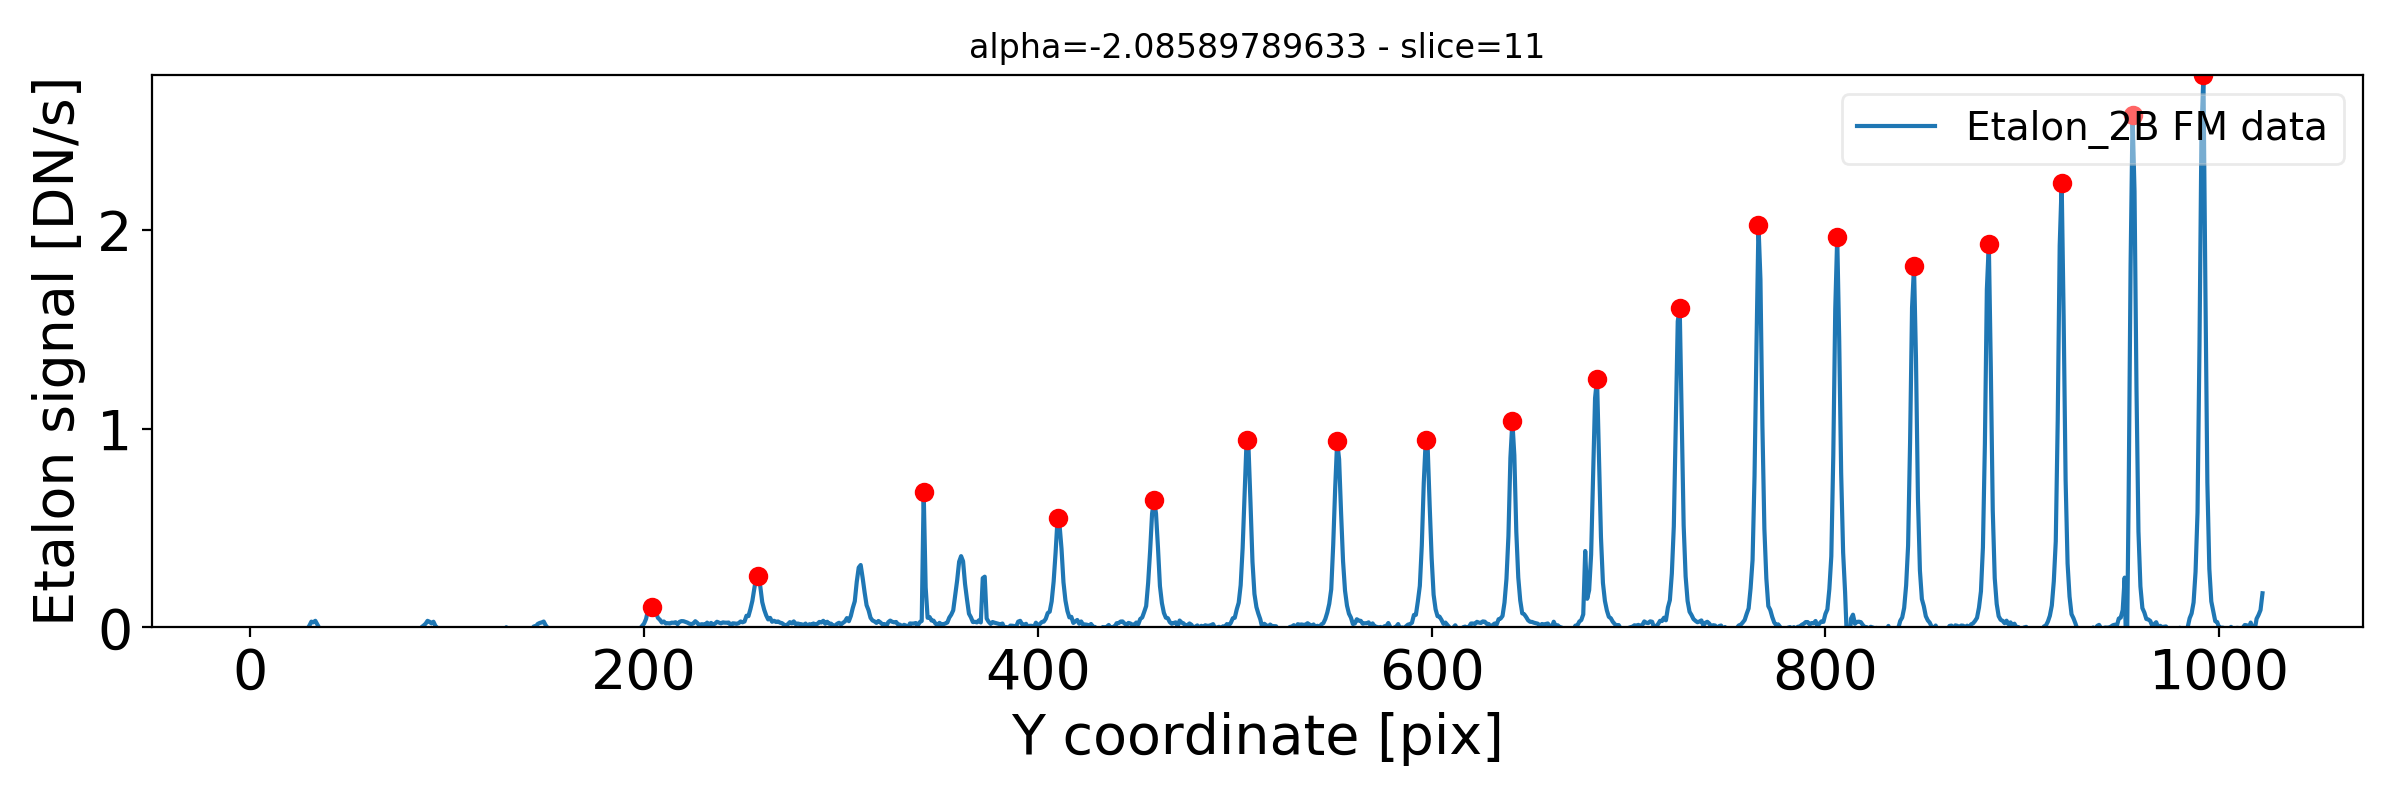

In [12]:
if band[0] in ['1','2']:
    fig,axs = plt.subplots(2,1,figsize=(12,8))
    axs[0].plot(etalon1A_fm_data,label='Etalon_1A FM data')
    axs[0].plot(FMetalon1A_peaks,etalon1A_fm_data[FMetalon1A_peaks],'ro')
    axs[0].set_ylim(0,etalon1A_fm_data[~np.isnan(etalon1A_fm_data)].max())
    axs[1].plot(etalon1B_fm_data,label='Etalon_1B FM data')
    axs[1].plot(FMetalon1B_peaks,etalon1B_fm_data[FMetalon1B_peaks],'ro')
    axs[1].set_ylim(0,etalon1B_fm_data[~np.isnan(etalon1B_fm_data)].max())
    for plot in range(2):
        axs[plot].set_xlabel('Y coordinate [pix]',fontsize=20)
        axs[plot].set_ylabel('Etalon signal [DN/s]',fontsize=20)
        axs[plot].tick_params(axis='both',labelsize=20)
        axs[plot].legend(loc='upper right',framealpha=0.4,fontsize=14)
    for plot in range(2): axs[plot].set_title("alpha="+str(alpha_pos)+' - slice='+str(islice))
    plt.tight_layout()

elif band[0] in ['4']:
    plt.figure(figsize=(12,4))
    plt.plot(etalon2B_fm_data,label='Etalon_2B FM data')
    plt.plot(FMetalon2B_peaks,etalon2B_fm_data[FMetalon2B_peaks],'ro')
    plt.ylim(0,etalon2B_fm_data[~np.isnan(etalon2B_fm_data)].max())
    plt.xlabel('Y coordinate [pix]',fontsize=20)
    plt.ylabel('Etalon signal [DN/s]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper right',framealpha=0.4,fontsize=14)
    plt.title("alpha="+str(alpha_pos)+' - slice='+str(islice))
    plt.tight_layout()

In [25]:
if band[0] in ['1','2']:
    FMetalon1A_fitparams,FMetalon1A_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1A_fm_data_noNaN,FMetalon1A_peaks,fit_func='skewed_voight',sigma0=sigma0_e1a,f0=0.5,a0=0.1)

    linecenter_ET1A = funcs.get_linecenter(FMetalon1A_fitparams,fitting_flag)
    linefwhm_ET1A   = funcs.get_FWHM(FMetalon1A_fitparams,fitting_flag)
    lineskew_ET1A   = funcs.get_skewness(FMetalon1A_fitparams,fitting_flag)

In [26]:
if band[0] in ['1','2']:
    linecenter = linecenter_ET1A
    linefwhm = linefwhm_ET1A
    lineskew = lineskew_ET1A

    sel1 = np.isfinite(np.array(linefwhm))
    popt1 = np.polyfit(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],3)
    sel2 = np.isfinite(np.array(lineskew))
    popt2 = np.polyfit(np.array(linecenter)[sel2],np.array(lineskew)[sel2],1)

    fig,axs = plt.subplots(1,2,figsize=(12,4))
    axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
    axs[0].plot(np.arange(len(etalon1A_fm_data_noNaN)),np.poly1d(popt1)(np.arange(len(etalon1A_fm_data_noNaN))),'b')
    axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
    axs[0].tick_params(axis='both',labelsize=20)
    axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
    axs[1].plot(np.arange(len(etalon1A_fm_data_noNaN)),np.poly1d(popt2)(np.arange(len(etalon1A_fm_data_noNaN))),'b')
    axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
    axs[1].tick_params(axis='both',labelsize=20)
    plt.tight_layout()

    # Plot the fits
    plt.figure(figsize=(12,4))
    plt.plot(etalon1A_fm_data_noNaN,'k',label='Etalon_1A FM data')
    #plt.vlines(cutoffpix,0,25,linestyle='dashed',label='reference point')
    funcs.plot_etalon_fit(FMetalon1A_fitparams,fitting_flag)
    plt.ylim(0,max(etalon1A_fm_data_noNaN))
    plt.xlabel('Y coordinate [pix]',fontsize=20)
    plt.ylabel('Signal [DN/s]',fontsize=20)
    plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper right',fontsize=14)
    plt.tight_layout()

In [27]:
if band[0] in ['1','2']:
    FMetalon1B_fitparams,FMetalon1B_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1B_fm_data_noNaN,FMetalon1B_peaks,fit_func='skewed_voight',sigma0=sigma0_e1b,f0=0.5,a0=0.1)

    linecenter_ET1B = funcs.get_linecenter(FMetalon1B_fitparams,fitting_flag)
    linefwhm_ET1B   = funcs.get_FWHM(FMetalon1B_fitparams,fitting_flag)
    lineskew_ET1B   = funcs.get_skewness(FMetalon1B_fitparams,fitting_flag)

In [28]:
if band[0] in ['1','2']:
    linecenter = linecenter_ET1B
    linefwhm = linefwhm_ET1B
    lineskew = lineskew_ET1B

    sel1 = np.isfinite(np.array(linefwhm))
    popt1 = np.polyfit(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],4)
    sel2 = np.isfinite(np.array(lineskew))
    popt2 = np.polyfit(np.array(linecenter)[sel2],np.array(lineskew)[sel2],1)

    fig,axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
    axs[0].plot(np.arange(det_dims[0]),np.poly1d(popt1)(np.arange(det_dims[0])))
    axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
    axs[0].tick_params(axis='both',labelsize=20)
    axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
    axs[1].plot(np.arange(det_dims[0]),np.poly1d(popt2)(np.arange(det_dims[0])))
    axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
    axs[1].tick_params(axis='both',labelsize=20)
    plt.tight_layout()

    plt.figure(figsize=(12,4))
    plt.plot(etalon1B_fm_data,'k',label='Etalon_1B FM data')
    funcs.plot_etalon_fit(FMetalon1B_fitparams,fitting_flag)
    plt.xlim(-50,1034)
    plt.ylim(0,max(etalon1B_fm_data[~np.isnan(etalon1B_fm_data)]))
    plt.xlabel('Y coordinate [pix]',fontsize=20)
    plt.ylabel('Signal [DN/s]',fontsize=20)
    plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper right',fontsize=14)
    plt.tight_layout()

In [29]:
if band[0] in ['4']:
    FMetalon2B_fitparams,FMetalon2B_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon2B_fm_data_noNaN,FMetalon2B_peaks,fit_func='skewed_voight',sigma0=sigma0_e2b,f0=0.5,a0=0.1)

    linecenter_ET2B = funcs.get_linecenter(FMetalon2B_fitparams,fitting_flag)
    linefwhm_ET2B   = funcs.get_FWHM(FMetalon2B_fitparams,fitting_flag)
    lineskew_ET2B   = funcs.get_skewness(FMetalon2B_fitparams,fitting_flag) 

<IPython.core.display.Javascript object>


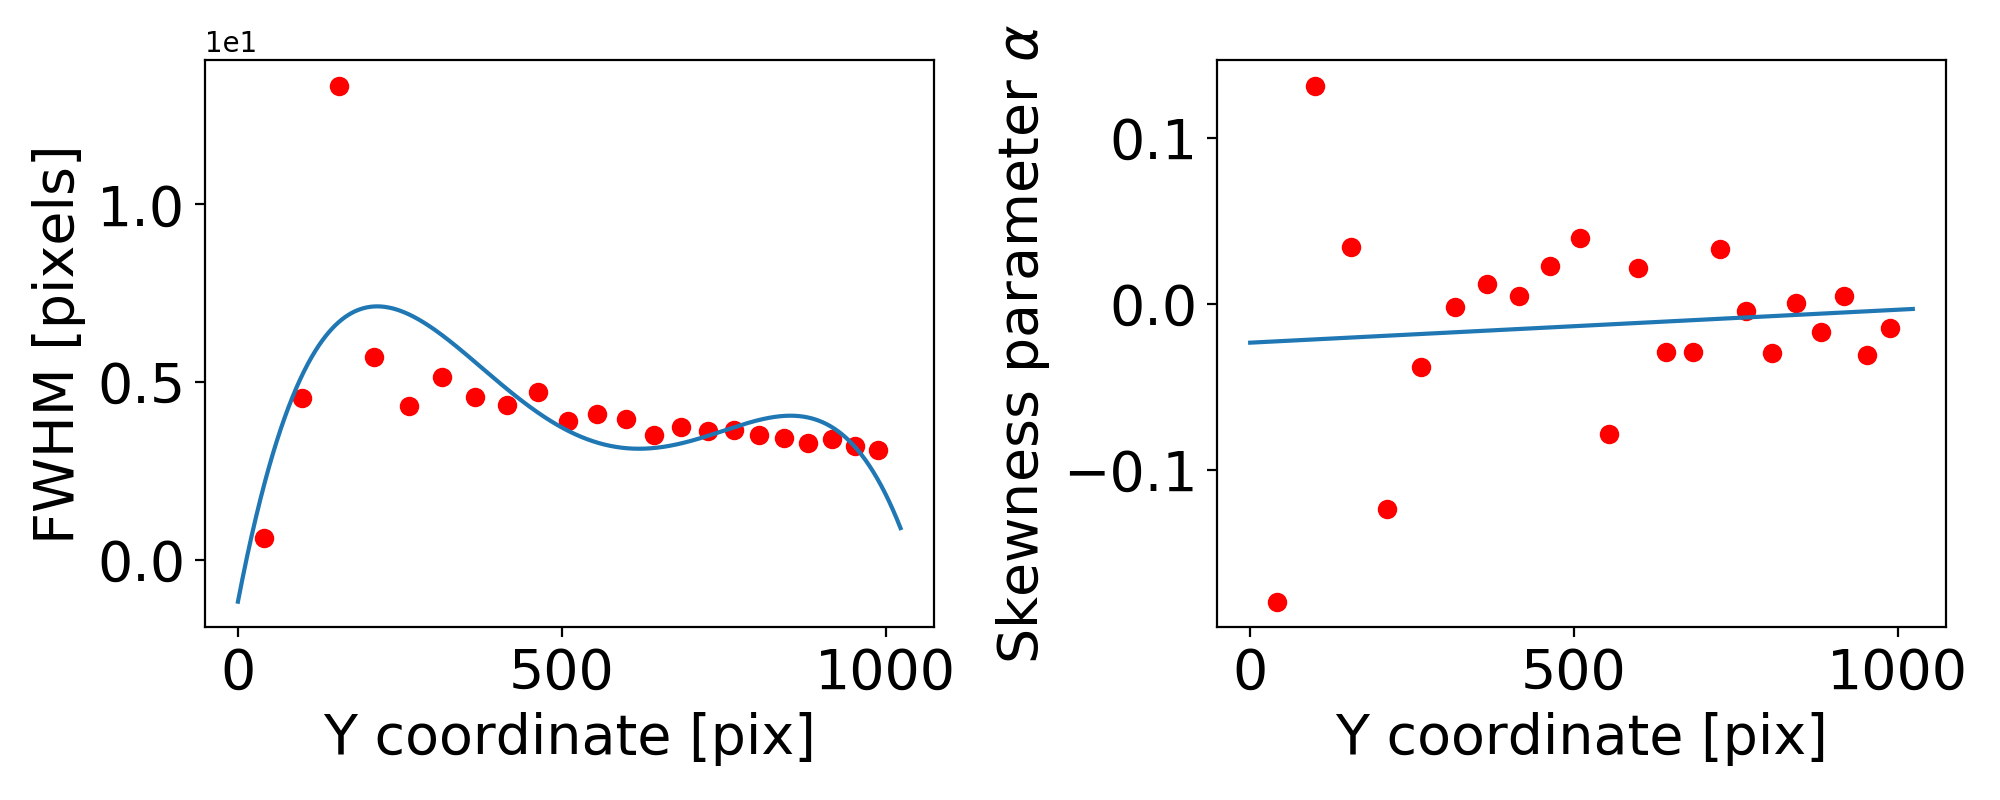

<IPython.core.display.Javascript object>


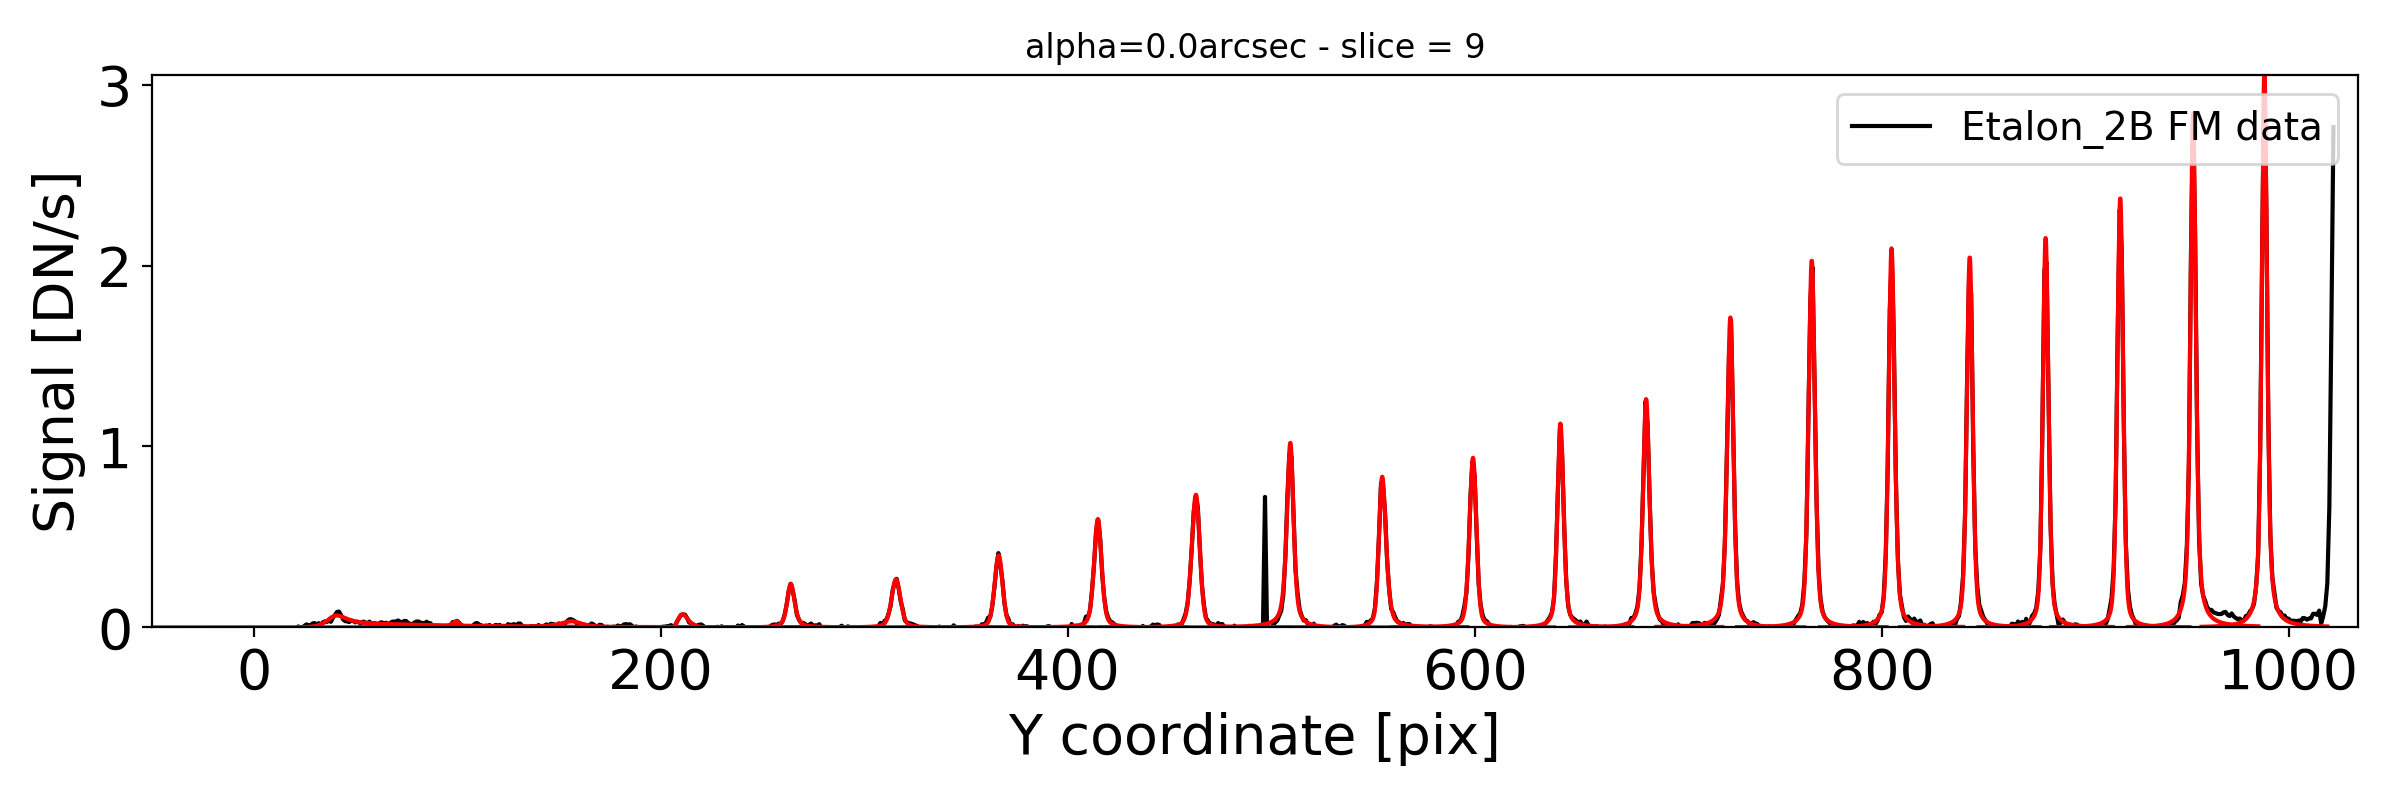

In [30]:
if band[0] in ['4']:
    linecenter = linecenter_ET2B
    linefwhm = linefwhm_ET2B
    lineskew = lineskew_ET2B

    sel1 = np.isfinite(np.array(linefwhm))
    popt1 = np.polyfit(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],4)
    sel2 = np.isfinite(np.array(lineskew))
    popt2 = np.polyfit(np.array(linecenter)[sel2],np.array(lineskew)[sel2],1)

    fig,axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
    axs[0].plot(np.arange(det_dims[0]),np.poly1d(popt1)(np.arange(det_dims[0])))
    axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
    axs[0].tick_params(axis='both',labelsize=20)
    axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
    axs[1].plot(np.arange(det_dims[0]),np.poly1d(popt2)(np.arange(det_dims[0])))
    axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
    axs[1].tick_params(axis='both',labelsize=20)
    plt.tight_layout()

    plt.figure(figsize=(12,4))
    plt.plot(etalon2B_fm_data,'k',label='Etalon_2B FM data')
    funcs.plot_etalon_fit(FMetalon2B_fitparams,fitting_flag)
    plt.xlim(-50,1034)
    plt.ylim(0,max(etalon2B_fm_data[~np.isnan(etalon2B_fm_data)]))
    plt.xlabel('Y coordinate [pix]',fontsize=20)
    plt.ylabel('Signal [DN/s]',fontsize=20)
    plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper right',fontsize=14)
    plt.tight_layout()

### Perform analysis for all alphas in slice

In [31]:
plot = False
for alpha_pos in alphas_inslice:
    if alpha_pos == alphas_inslice[0]:
        print 'Along-slice position:'
    print  '                     {} arcsec'.format(round(alpha_pos,2))
    # Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)
    if band == '1C':
        xpos[0] = xpos[1]
        xpos[-1] = xpos[-2]
        
    if band[0] in ['1','2']:
        # Choose data regions
        #--FM data
        etalon1A_fm_data = etalon1A_img[ypos,xpos]
        etalon1B_fm_data = etalon1B_img[ypos,xpos]

        # Determine etalon peaks
        #--FM Etalon_1A data
        if user == 'yannis':
            etalon1A_fm_data[np.isnan(etalon1A_fm_data)] = -1
            FMetalon1A_peaks = funcs.find_peaks(etalon1A_fm_data,thres=thres_e1a,min_dist=min_dist_e1a)
            FMetalon1A_peaks = FMetalon1A_peaks[(FMetalon1A_peaks>1) & (FMetalon1A_peaks<1022)]
        if user == 'alvaro':
            picos_1A, y_pixs_1A = funcs.find_max(etalon1A_fm_data,np.arange(1,1025,1.),maxcut_1a,toler_1a) # maxcut, wavel_toler
            picos_inds_1A = y_pixs_1A-1
            FMetalon1A_peaks = picos_inds_1A.astype(int)
        etalon1A_fm_data[(etalon1A_fm_data == -1)] = np.nan
        etalon1A_fm_data_noNaN = etalon1A_fm_data.copy()
        etalon1A_fm_data_noNaN[np.isnan(etalon1A_fm_data)] = 0.

        #--FM Etalon_1B data
        if user == 'yannis':
            etalon1B_fm_data[np.isnan(etalon1B_fm_data)] = -1
            FMetalon1B_peaks = funcs.find_peaks(etalon1B_fm_data,thres=thres_e1b,min_dist=min_dist_e1b)
            FMetalon1B_peaks = FMetalon1B_peaks[(FMetalon1B_peaks>1) & (FMetalon1B_peaks<1022)]
        if user == 'alvaro':
            picos_1B, y_pixs_1B = funcs.find_max(etalon1B_fm_data,np.arange(1,1025,1.),maxcut_1b,toler_1b) # maxcut, wavel_toler
            picos_inds_1B = y_pixs_1B-1
            FMetalon1B_peaks = picos_inds_1B.astype(int)
        etalon1B_fm_data[(etalon1B_fm_data == -1)] = np.nan
        etalon1B_fm_data_noNaN = etalon1B_fm_data.copy()
        etalon1B_fm_data_noNaN[np.isnan(etalon1B_fm_data)] = 0.

        # Fit Etalon_1A lines in FM data
        FMetalon1A_fitparams,FMetalon1A_fiterrors,ET1A_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1A_fm_data_noNaN,FMetalon1A_peaks,fit_func='skewed_voight',sigma0=sigma0_e1a,f0=0.5,a0=0.1)
        linecenter_ET1A = funcs.get_linecenter(FMetalon1A_fitparams,ET1A_fitting_flag)
        linefwhm_ET1A   = funcs.get_FWHM(FMetalon1A_fitparams,ET1A_fitting_flag)
        lineskew_ET1A   = funcs.get_skewness(FMetalon1A_fitparams,ET1A_fitting_flag)

        # Fit Etalon_1B lines in FM data
        FMetalon1B_fitparams,FMetalon1B_fiterrors,ET1B_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1B_fm_data_noNaN,FMetalon1B_peaks,fit_func='skewed_voight',sigma0=sigma0_e1b,f0=0.5,a0=0.1)
        linecenter_ET1B = funcs.get_linecenter(FMetalon1B_fitparams,ET1B_fitting_flag)
        linefwhm_ET1B   = funcs.get_FWHM(FMetalon1B_fitparams,ET1B_fitting_flag)
        lineskew_ET1B   = funcs.get_skewness(FMetalon1B_fitparams,ET1B_fitting_flag)

        # SAVES fits of FM - ETALON 1A
        for zzz in range(0,np.size(FMetalon1A_peaks),1):
            save_et1a.write(str(alpha_pos)+'  '+str(xpos[FMetalon1A_peaks[zzz]])+'  '+str(FMetalon1A_peaks[zzz])+'  '+str(linecenter_ET1A[zzz])+'  '+str(linefwhm_ET1A[zzz])+'  '+str(lineskew_ET1A[zzz])+'\n')

        # SALVA fits of FM - ETALON 1B
        for zzz in range(0,np.size(FMetalon1B_peaks),1):
            save_et1b.write(str(alpha_pos)+'  '+str(xpos[FMetalon1B_peaks[zzz]])+'  '+str(FMetalon1B_peaks[zzz])+'  '+str(linecenter_ET1B[zzz])+'  '+str(linefwhm_ET1B[zzz])+'  '+str(lineskew_ET1B[zzz])+'\n')
    
    elif band[0] in ['4']:
        #--FM data
        etalon2B_fm_data = etalon2B_img[ypos,xpos]

        # Determine etalon peaks
        #--FM Etalon_2B data
        if user == 'yannis':
            etalon2B_fm_data[np.isnan(etalon2B_fm_data)] = -1
            FMetalon2B_peaks = funcs.find_peaks(etalon2B_fm_data,thres=thres_e2b,min_dist=min_dist_e2b)
            FMetalon2B_peaks = FMetalon2B_peaks[(FMetalon2B_peaks>1) & (FMetalon2B_peaks<1022) & (etalon2B_fm_data[FMetalon2B_peaks]>0)]
        if user == 'alvaro':
            picos_2B, y_pixs_2B = funcs.find_max(etalon2B_fm_data,np.arange(1,1025,1.),maxcut_1a,toler_1a) # maxcut, wavel_toler
            picos_inds_2B = y_pixs_2B-1
            FMetalon2B_peaks = picos_inds_2B.astype(int)
        etalon2B_fm_data[(etalon2B_fm_data == -1)] = np.nan
        etalon2B_fm_data_noNaN = etalon2B_fm_data.copy()
        etalon2B_fm_data_noNaN[np.isnan(etalon2B_fm_data)] = 0.
        
        # Fit Etalon_2B lines in FM data
        FMetalon2B_fitparams,FMetalon2B_fiterrors,ET2B_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon2B_fm_data_noNaN,FMetalon2B_peaks,fit_func='skewed_voight',sigma0=sigma0_e2b,f0=0.5,a0=0.1)
        linecenter_ET2B = funcs.get_linecenter(FMetalon2B_fitparams,ET2B_fitting_flag)
        linefwhm_ET2B   = funcs.get_FWHM(FMetalon2B_fitparams,ET2B_fitting_flag)
        lineskew_ET2B   = funcs.get_skewness(FMetalon2B_fitparams,ET2B_fitting_flag)
        
        # SAVES fits of FM - ETALON 2B
        for zzz in range(0,np.size(FMetalon2B_peaks),1):
            save_et2b.write(str(alpha_pos)+'  '+str(xpos[FMetalon2B_peaks[zzz]])+'  '+str(FMetalon2B_peaks[zzz])+'  '+str(linecenter_ET2B[zzz])+'  '+str(linefwhm_ET2B[zzz])+'  '+str(lineskew_ET2B[zzz])+'\n')
        
if band[0] in ['1','2']:
    save_et1a.close()
    save_et1b.close()
elif band[0] in ['4']:
    save_et2b.close()

Along-slice position:
                     0.0 arcsec
                     -2.7 arcsec
                     -2.43 arcsec
                     -2.17 arcsec


/Users/ioannisa/Desktop/python/miri_devel/funcs.py:1027: RuntimeWarning: overflow encountered in exp
  sigma = 2*sigma0 / (1+np.exp(a*(x-mu)))
/Users/ioannisa/Desktop/python/miri_devel/funcs.py:1028: RuntimeWarning: divide by zero encountered in divide
  G_nu = (A/sigma) * np.sqrt(4*np.log(2)/np.pi) * np.exp(-4*np.log(2)*((x-mu)/sigma)**2)
/Users/ioannisa/Desktop/python/miri_devel/funcs.py:1028: RuntimeWarning: overflow encountered in square
  G_nu = (A/sigma) * np.sqrt(4*np.log(2)/np.pi) * np.exp(-4*np.log(2)*((x-mu)/sigma)**2)
/Users/ioannisa/Desktop/python/miri_devel/funcs.py:1028: RuntimeWarning: invalid value encountered in multiply
  G_nu = (A/sigma) * np.sqrt(4*np.log(2)/np.pi) * np.exp(-4*np.log(2)*((x-mu)/sigma)**2)
/Users/ioannisa/Desktop/python/miri_devel/funcs.py:1029: RuntimeWarning: divide by zero encountered in divide
  L_nu = (2*A/(np.pi*sigma))/(1+4*((x-mu)/sigma)**2)
/Users/ioannisa/Desktop/python/miri_devel/funcs.py:1029: RuntimeWarning: overflow encountered in squar

                     -1.9 arcsec
                     -1.64 arcsec
                     -1.37 arcsec
                     -1.1 arcsec
                     -0.84 arcsec
                     -0.57 arcsec
                     -0.31 arcsec
                     -0.04 arcsec
                     0.22 arcsec
                     0.49 arcsec
                     0.75 arcsec
                     1.02 arcsec
                     1.29 arcsec
                     1.55 arcsec
                     1.82 arcsec
                     2.08 arcsec
                     2.35 arcsec
                     2.61 arcsec
                     2.88 arcsec
                     3.15 arcsec
                     3.41 arcsec
                     3.68 arcsec
